In [1]:
import os

# W&B 로깅을 완전히 비활성화합니다.
os.environ['WANDB_MODE'] = 'disabled'

In [2]:
!pip install torch torchvision transformers
!pip install accelerate peft
!pip install pillow requests
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 10.8 MB/s eta 0:00:00


In [3]:
# Google Drive 마운트 (파인튜닝된 모델 로드에 필요할 경우)
from google.colab import drive
import os
if not os.path.exists("/content/drive"):
    drive.mount("/content/drive")
    print("✅ Google Drive 마운트 완료")
else:
    print("✅ Google Drive가 이미 마운트되어 있습니다.")

import torch
import torch.nn as nn
from transformers import (
    AutoProcessor,
    AutoModelForVision2Seq,
    BitsAndBytesConfig
)
from peft import PeftModel
from PIL import Image
import warnings

# 경고 무시 (선택적)
warnings.filterwarnings("ignore")

# CUDA 장치 설정
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"✅ 라이브러리 로드 완료. 사용 장치: {DEVICE}")

Mounted at /content/drive
✅ Google Drive 마운트 완료
✅ 라이브러리 로드 완료. 사용 장치: cuda


In [4]:
# ====================================
# 📝 설정
# ====================================

# 모델 설정
BASE_MODEL_ID = "llava-hf/llava-1.5-7b-hf"

# QLoRA 설정 (8비트 모델 로드)
QLORA_CONFIG = {
    "load_in_8bit": True,
}

# 생성 설정
GENERATION_CONFIG = {
    "max_new_tokens": 200,
    "temperature": 0.7,
    "do_sample": True
}

# ====================================
# 🚀 추론 함수 정의
# ====================================

def generate_response(model, processor, image_path, question):
    """주어진 모델과 프로세서로 이미지-텍스트 생성"""
    try:
        # 1. 이미지 로드 및 전처리
        image = Image.open(image_path).convert('RGB')

        # 2. LLaVA 프롬프트 형식
        # USER: <image>\n{question} ASSISTANT:
        prompt = f"USER: <image>\n{question} ASSISTANT:"

        # 3. 입력 인코딩 및 장치 이동
        inputs = processor(image, prompt, return_tensors='pt').to(model.device)

        # 4. 텍스트 생성
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                pad_token_id=processor.tokenizer.pad_token_id,
                **GENERATION_CONFIG
            )

        # 5. 결과 디코딩 및 정리
        response = processor.decode(outputs[0], skip_special_tokens=True)
        # 응답 텍스트에서 'ASSISTANT:' 이후 부분만 추출
        answer = response.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response else response

        # 이미지 시각화 (선택적)
        print("\n[Image of the input image]", end="\n\n")

        print(f"📝 입력 질문: {question}")
        print("-" * 50)
        print(f"🤖 응답: {answer}")
        print("-" * 50)

    except FileNotFoundError:
        print(f"❌ 오류: 이미지 파일 '{image_path}'를 찾을 수 없습니다.")
    except Exception as e:
        print(f"❌ 오류 발생: {e}")

print("✅ 설정 및 추론 함수 정의 완료")

✅ 설정 및 추론 함수 정의 완료


In [5]:
# ====================================
# 1️⃣ 기반 모델 로드
# ====================================
print("📥 기반 모델 로드 중...")

# 8비트 설정을 위한 BitsAndBytesConfig
bnb_config = BitsAndBytesConfig(**QLORA_CONFIG)

# 프로세서 로드 (토크나이저 및 이미지 전처리)
base_processor = AutoProcessor.from_pretrained(BASE_MODEL_ID)
if base_processor.tokenizer.pad_token is None:
    base_processor.tokenizer.pad_token = base_processor.tokenizer.eos_token

# 모델 로드 (8비트 로드)
# torch_dtype을 float16으로 설정하여 VRAM 사용량을 줄입니다.
base_model = AutoModelForVision2Seq.from_pretrained(
    BASE_MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16
)

base_model.eval() # 추론 모드 설정

print("✅ 기반 모델 로드 및 설정 완료!")
print("-" * 50)

📥 기반 모델 로드 중...


processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/674 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

✅ 기반 모델 로드 및 설정 완료!
--------------------------------------------------


In [6]:
from google.colab import files
from PIL import Image
import io

🚀 파인튜닝된 모델로 추론 시작...


Saving test (1).jpg to test (1).jpg
--------------------------------------------------
📝 입력 질문: What do you see in this image? Please elaborate.

--- 🤖 파인튜닝 모델 응답 ---


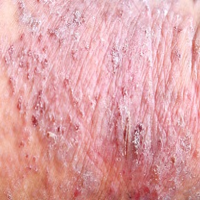

🤖 응답: The image showcases the back of a person with a skin condition. The skin appears rough and covered in white powder, likely salt or a similar substance, which can be used as a treatment for the skin condition. The person's back is the main focus of the image, emphasizing the unusual appearance of their skin.
--------------------------------------------------


In [ ]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (간소화)
# ====================================

from IPython.display import display



FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_03"


ft_model = base_model

ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)

print("🚀 파인튜닝된 모델로 추론 시작...")


uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # 2. 텍스트 입력

    TEST_QUESTION_FT = "What do you see in this image? Please elaborate."

    # LLaVA 프롬프트 형식
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT} ASSISTANT:"

    print("-" * 50)
    print(f"📝 입력 질문: {TEST_QUESTION_FT}")

    try:
        # 입력 인코딩 및 장치 이동 (base_processor는 셀 3 상단에서 로드됨)
        # ft_model은 셀 4 상단에서 로드됨
        inputs_ft = base_processor(image_ft, prompt_ft, return_tensors='pt').to(ft_model.device)

        # 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
              **inputs_ft,
              pad_token_id=base_processor.tokenizer.pad_token_id,
              **GENERATION_CONFIG
            )

        # 결과 디코딩 및 정리
        response_ft = base_processor.decode(outputs_ft[0], skip_special_tokens=True)
        answer_ft = response_ft.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response_ft else response_ft

        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200))) # 업로드된 이미지 미리보기
        print(f"🤖 응답: {answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_78220_P0_L0.png to Z4_78220_P0_L0.png
--------------------------------------------------
📝 입력 질문: What do you see in this image? Please elaborate.

--- 🤖 파인튜닝 모델 응답 ---


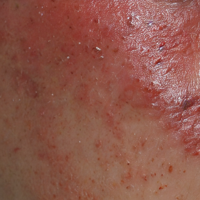

🤖 응답: In the image, a person is seen with their face, particularly the cheek and forehead, covered in red, irritated skin. The person appears to be experiencing a skin condition or inflammation. The redness spreads across a large area of their face, making it a prominent feature.
--------------------------------------------------


In [ ]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (간소화)
# ====================================

from IPython.display import display



FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_03"


ft_model = base_model

ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)

print("🚀 파인튜닝된 모델로 추론 시작...")


uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # 2. 텍스트 입력

    TEST_QUESTION_FT = "What do you see in this image? Please elaborate."

    # LLaVA 프롬프트 형식
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT} ASSISTANT:"

    print("-" * 50)
    print(f"📝 입력 질문: {TEST_QUESTION_FT}")

    try:
        # 입력 인코딩 및 장치 이동 (base_processor는 셀 3 상단에서 로드됨)
        # ft_model은 셀 4 상단에서 로드됨
        inputs_ft = base_processor(image_ft, prompt_ft, return_tensors='pt').to(ft_model.device)

        # 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
              **inputs_ft,
              pad_token_id=base_processor.tokenizer.pad_token_id,
              **GENERATION_CONFIG
            )

        # 결과 디코딩 및 정리
        response_ft = base_processor.decode(outputs_ft[0], skip_special_tokens=True)
        answer_ft = response_ft.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response_ft else response_ft

        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200))) # 업로드된 이미지 미리보기
        print(f"🤖 응답: {answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_116430_P0_L0.png to Z4_116430_P0_L0.png
--------------------------------------------------
📝 입력 질문: What do you see in this image? Please elaborate.

--- 🤖 파인튜닝 모델 응답 ---


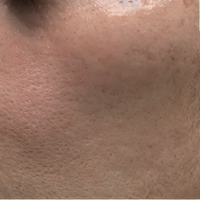

🤖 응답: In the image, a close-up view of a man's skin is shown. The man has a noticeable amount of facial hair, with a thick beard and a prominent mustache. The beard appears to be relatively full, and the mustache is well-groomed, giving the man a distinguished look.
--------------------------------------------------


In [ ]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (간소화)
# ====================================

from IPython.display import display



FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_03"


ft_model = base_model

ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)

print("🚀 파인튜닝된 모델로 추론 시작...")


uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # 2. 텍스트 입력

    TEST_QUESTION_FT = "What do you see in this image? Please elaborate."

    # LLaVA 프롬프트 형식
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT} ASSISTANT:"

    print("-" * 50)
    print(f"📝 입력 질문: {TEST_QUESTION_FT}")

    try:
        # 입력 인코딩 및 장치 이동 (base_processor는 셀 3 상단에서 로드됨)
        # ft_model은 셀 4 상단에서 로드됨
        inputs_ft = base_processor(image_ft, prompt_ft, return_tensors='pt').to(ft_model.device)

        # 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
              **inputs_ft,
              pad_token_id=base_processor.tokenizer.pad_token_id,
              **GENERATION_CONFIG
            )

        # 결과 디코딩 및 정리
        response_ft = base_processor.decode(outputs_ft[0], skip_special_tokens=True)
        answer_ft = response_ft.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response_ft else response_ft

        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200))) # 업로드된 이미지 미리보기
        print(f"🤖 응답: {answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_89118_P0_L0.png to Z4_89118_P0_L0.png
--------------------------------------------------
📝 입력 질문: What do you see in this image? Please elaborate.

--- 🤖 파인튜닝 모델 응답 ---


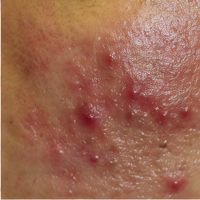

🤖 응답: The image features the back of a person with a large, pimple-like blemish that stretches across a significant portion of the skin. The surface of the skin appears to be sensitive, with red and sore-looking bumps scattered across its surface. The blemish seems to be irritated and inflamed, potentially affecting the individual's appearance and comfort.
--------------------------------------------------


In [ ]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (간소화)
# ====================================

from IPython.display import display



FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_03"


ft_model = base_model

ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)

print("🚀 파인튜닝된 모델로 추론 시작...")


uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # 2. 텍스트 입력

    TEST_QUESTION_FT = "What do you see in this image? Please elaborate."

    # LLaVA 프롬프트 형식
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT} ASSISTANT:"

    print("-" * 50)
    print(f"📝 입력 질문: {TEST_QUESTION_FT}")

    try:
        # 입력 인코딩 및 장치 이동 (base_processor는 셀 3 상단에서 로드됨)
        # ft_model은 셀 4 상단에서 로드됨
        inputs_ft = base_processor(image_ft, prompt_ft, return_tensors='pt').to(ft_model.device)

        # 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
              **inputs_ft,
              pad_token_id=base_processor.tokenizer.pad_token_id,
              **GENERATION_CONFIG
            )

        # 결과 디코딩 및 정리
        response_ft = base_processor.decode(outputs_ft[0], skip_special_tokens=True)
        answer_ft = response_ft.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response_ft else response_ft

        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200))) # 업로드된 이미지 미리보기
        print(f"🤖 응답: {answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_84015_P0_L0.png to Z4_84015_P0_L0.png
--------------------------------------------------
📝 입력 질문: What do you see in this image? Please elaborate.

--- 🤖 파인튜닝 모델 응답 ---


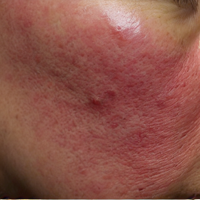

🤖 응답: The image features a close-up view of a person's face, likely a woman. The face is plump and has an uneven skin tone. There are red spots and bumps on the lower part of the face, giving the appearance of a spider bite. The skin around the face seems to be irritated and is showing redness. The person's face is captured in detail, showing their features and the skin conditions.
--------------------------------------------------


In [ ]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (간소화)
# ====================================

from IPython.display import display



FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_03"


ft_model = base_model

ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)

print("🚀 파인튜닝된 모델로 추론 시작...")


uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # 2. 텍스트 입력

    TEST_QUESTION_FT = "What do you see in this image? Please elaborate."

    # LLaVA 프롬프트 형식
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT} ASSISTANT:"

    print("-" * 50)
    print(f"📝 입력 질문: {TEST_QUESTION_FT}")

    try:
        # 입력 인코딩 및 장치 이동 (base_processor는 셀 3 상단에서 로드됨)
        # ft_model은 셀 4 상단에서 로드됨
        inputs_ft = base_processor(image_ft, prompt_ft, return_tensors='pt').to(ft_model.device)

        # 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
              **inputs_ft,
              pad_token_id=base_processor.tokenizer.pad_token_id,
              **GENERATION_CONFIG
            )

        # 결과 디코딩 및 정리
        response_ft = base_processor.decode(outputs_ft[0], skip_special_tokens=True)
        answer_ft = response_ft.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response_ft else response_ft

        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200))) # 업로드된 이미지 미리보기
        print(f"🤖 응답: {answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_94032_P0_L0.png to Z4_94032_P0_L0.png
--------------------------------------------------
📝 입력 질문: What do you see in this image? Please elaborate.

--- 🤖 파인튜닝 모델 응답 ---


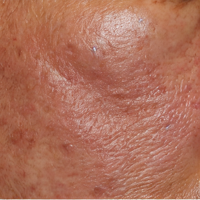

🤖 응답: The image displays a close-up of an individual's face with an emphasis on their forehead. The forehead appears to have a noticeable bump, which gives it a unique shape. The area surrounding the bump is covered with pimples, making it a noticeable feature on the person's face.
--------------------------------------------------


In [ ]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (간소화)
# ====================================

from IPython.display import display



FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_03"


ft_model = base_model

ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)

print("🚀 파인튜닝된 모델로 추론 시작...")


uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # 2. 텍스트 입력

    TEST_QUESTION_FT = "What do you see in this image? Please elaborate."

    # LLaVA 프롬프트 형식
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT} ASSISTANT:"

    print("-" * 50)
    print(f"📝 입력 질문: {TEST_QUESTION_FT}")

    try:
        # 입력 인코딩 및 장치 이동 (base_processor는 셀 3 상단에서 로드됨)
        # ft_model은 셀 4 상단에서 로드됨
        inputs_ft = base_processor(image_ft, prompt_ft, return_tensors='pt').to(ft_model.device)

        # 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
              **inputs_ft,
              pad_token_id=base_processor.tokenizer.pad_token_id,
              **GENERATION_CONFIG
            )

        # 결과 디코딩 및 정리
        response_ft = base_processor.decode(outputs_ft[0], skip_special_tokens=True)
        answer_ft = response_ft.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response_ft else response_ft

        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200))) # 업로드된 이미지 미리보기
        print(f"🤖 응답: {answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving test (1).jpg to test (1) (1).jpg
--------------------------------------------------
📝 입력 질문: 이미지에 보이는 피부질환을 설명해줘

--- 🤖 파인튜닝 모델 응답 ---


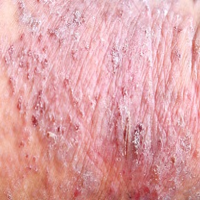

🤖 응답: The image displays a close-up view of a person's arm with a skin condition, such as psoriasis, visible in the form of dry and flaky skin. This condition leads to skin scaling and can be painful or uncomfortable for the individual. The affected area appears red and scaly, indicating the progression of the condition. Psoriasis is a chronic autoimmune disorder that affects the skin and can cause patches of thick, red, and scaly skin that may be itchy or painful. It can be managed with medication and proper skin care.
--------------------------------------------------


In [ ]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (간소화)
# ====================================

from IPython.display import display



FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_03"


ft_model = base_model

ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)

print("🚀 파인튜닝된 모델로 추론 시작...")


uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # 2. 텍스트 입력

    TEST_QUESTION_FT = "이미지에 보이는 피부질환을 설명해줘"

    # LLaVA 프롬프트 형식
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT} ASSISTANT:"

    print("-" * 50)
    print(f"📝 입력 질문: {TEST_QUESTION_FT}")

    try:
        # 입력 인코딩 및 장치 이동 (base_processor는 셀 3 상단에서 로드됨)
        # ft_model은 셀 4 상단에서 로드됨
        inputs_ft = base_processor(image_ft, prompt_ft, return_tensors='pt').to(ft_model.device)

        # 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
              **inputs_ft,
              pad_token_id=base_processor.tokenizer.pad_token_id,
              **GENERATION_CONFIG
            )

        # 결과 디코딩 및 정리
        response_ft = base_processor.decode(outputs_ft[0], skip_special_tokens=True)
        answer_ft = response_ft.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response_ft else response_ft

        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200))) # 업로드된 이미지 미리보기
        print(f"🤖 응답: {answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_78220_P0_L0.png to Z4_78220_P0_L0 (1).png
--------------------------------------------------
📝 입력 질문: 이미지에 보이는 피부질환을 설명해줘

--- 🤖 파인튜닝 모델 응답 ---


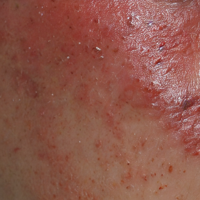

🤖 응답: 이미지에서 보이는 피부질환은 피부에 대한 질환을 말한다. 이 질환은 주로 층이 통통하게 확장되어 침전이나 피부 부위에서 발생하는 이상적인 질병을 의미한다. 이 질환은 처치 방법과 진단 결과에 따라 다양한 형태로 변화할 수 있다. 이
--------------------------------------------------


In [ ]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (간소화)
# ====================================

from IPython.display import display



FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_03"


ft_model = base_model

ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)

print("🚀 파인튜닝된 모델로 추론 시작...")


uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # 2. 텍스트 입력

    TEST_QUESTION_FT = "이미지에 보이는 피부질환을 설명해줘"

    # LLaVA 프롬프트 형식
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT} ASSISTANT:"

    print("-" * 50)
    print(f"📝 입력 질문: {TEST_QUESTION_FT}")

    try:
        # 입력 인코딩 및 장치 이동 (base_processor는 셀 3 상단에서 로드됨)
        # ft_model은 셀 4 상단에서 로드됨
        inputs_ft = base_processor(image_ft, prompt_ft, return_tensors='pt').to(ft_model.device)

        # 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
              **inputs_ft,
              pad_token_id=base_processor.tokenizer.pad_token_id,
              **GENERATION_CONFIG
            )

        # 결과 디코딩 및 정리
        response_ft = base_processor.decode(outputs_ft[0], skip_special_tokens=True)
        answer_ft = response_ft.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response_ft else response_ft

        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200))) # 업로드된 이미지 미리보기
        print(f"🤖 응답: {answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_116430_P0_L0.png to Z4_116430_P0_L0 (1).png
--------------------------------------------------
📝 입력 질문: 이미지에 보이는 피부질환을 설명해줘

--- 🤖 파인튜닝 모델 응답 ---


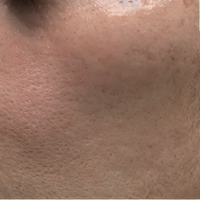

🤖 응답: 이미지에는 피부 질환을 설명하는 말이 담긴 엘리버트가 있습니다. 이 엘리버트는 이미지 사이트에서 제공되고 있으며, 질환을 줄이기 위한 방법으로 사용됩니다. 이 엘리버트는 새로운 피부를 만드는 비타민 A와 함께 사용되어 피부를 보호하고 유지하
--------------------------------------------------


In [ ]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (간소화)
# ====================================

from IPython.display import display



FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_03"


ft_model = base_model

ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)

print("🚀 파인튜닝된 모델로 추론 시작...")


uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # 2. 텍스트 입력

    TEST_QUESTION_FT = "이미지에 보이는 피부질환을 설명해줘"

    # LLaVA 프롬프트 형식
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT} ASSISTANT:"

    print("-" * 50)
    print(f"📝 입력 질문: {TEST_QUESTION_FT}")

    try:
        # 입력 인코딩 및 장치 이동 (base_processor는 셀 3 상단에서 로드됨)
        # ft_model은 셀 4 상단에서 로드됨
        inputs_ft = base_processor(image_ft, prompt_ft, return_tensors='pt').to(ft_model.device)

        # 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
              **inputs_ft,
              pad_token_id=base_processor.tokenizer.pad_token_id,
              **GENERATION_CONFIG
            )

        # 결과 디코딩 및 정리
        response_ft = base_processor.decode(outputs_ft[0], skip_special_tokens=True)
        answer_ft = response_ft.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response_ft else response_ft

        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200))) # 업로드된 이미지 미리보기
        print(f"🤖 응답: {answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_89118_P0_L0.png to Z4_89118_P0_L0 (1).png
--------------------------------------------------
📝 입력 질문: 이미지에 보이는 피부질환을 설명해줘

--- 🤖 파인튜닝 모델 응답 ---


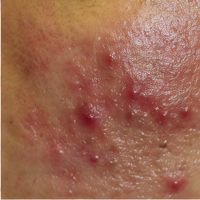

🤖 응답: 이미지에서 보이는 피부질환(cystic acne)은 피부의 수많은 행동포(sebaceous gland)들의 과민증후(inflammation) 과도로 인해 들어있는 적게 표현되는 병인설환(infections)으로 인해 생겨난다는 것을 설명합니다. 이 질환은 대개 피부의 중심부에 발생하며, 감염 ��
--------------------------------------------------


In [ ]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (간소화)
# ====================================

from IPython.display import display



FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_03"


ft_model = base_model

ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)

print("🚀 파인튜닝된 모델로 추론 시작...")


uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # 2. 텍스트 입력

    TEST_QUESTION_FT = "이미지에 보이는 피부질환을 설명해줘"

    # LLaVA 프롬프트 형식
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT} ASSISTANT:"

    print("-" * 50)
    print(f"📝 입력 질문: {TEST_QUESTION_FT}")

    try:
        # 입력 인코딩 및 장치 이동 (base_processor는 셀 3 상단에서 로드됨)
        # ft_model은 셀 4 상단에서 로드됨
        inputs_ft = base_processor(image_ft, prompt_ft, return_tensors='pt').to(ft_model.device)

        # 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
              **inputs_ft,
              pad_token_id=base_processor.tokenizer.pad_token_id,
              **GENERATION_CONFIG
            )

        # 결과 디코딩 및 정리
        response_ft = base_processor.decode(outputs_ft[0], skip_special_tokens=True)
        answer_ft = response_ft.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response_ft else response_ft

        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200))) # 업로드된 이미지 미리보기
        print(f"🤖 응답: {answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_84015_P0_L0.png to Z4_84015_P0_L0 (1).png
--------------------------------------------------
📝 입력 질문: 이미지에 보이는 피부질환을 설명해줘

--- 🤖 파인튜닝 모델 응답 ---


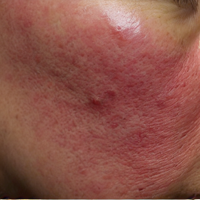

🤖 응답: 이미지에 보이는 피부질환은 피부에 대한 감각이나 상태변화에 대한 감각을 일으켜주는 신체적인 반응입니다. 이 반응은 피부질환 기관의 활동으로 알려져 있으며, 피부질환 기관은 피부와 전신에서 일어나는 생리적인 작용을
--------------------------------------------------


In [ ]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (간소화)
# ====================================

from IPython.display import display



FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_03"


ft_model = base_model

ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)

print("🚀 파인튜닝된 모델로 추론 시작...")


uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # 2. 텍스트 입력

    TEST_QUESTION_FT = "이미지에 보이는 피부질환을 설명해줘"

    # LLaVA 프롬프트 형식
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT} ASSISTANT:"

    print("-" * 50)
    print(f"📝 입력 질문: {TEST_QUESTION_FT}")

    try:
        # 입력 인코딩 및 장치 이동 (base_processor는 셀 3 상단에서 로드됨)
        # ft_model은 셀 4 상단에서 로드됨
        inputs_ft = base_processor(image_ft, prompt_ft, return_tensors='pt').to(ft_model.device)

        # 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
              **inputs_ft,
              pad_token_id=base_processor.tokenizer.pad_token_id,
              **GENERATION_CONFIG
            )

        # 결과 디코딩 및 정리
        response_ft = base_processor.decode(outputs_ft[0], skip_special_tokens=True)
        answer_ft = response_ft.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response_ft else response_ft

        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200))) # 업로드된 이미지 미리보기
        print(f"🤖 응답: {answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_94032_P0_L0.png to Z4_94032_P0_L0 (1).png
--------------------------------------------------
📝 입력 질문: 이미지에 보이는 피부질환을 설명해줘

--- 🤖 파인튜닝 모델 응답 ---


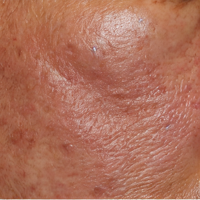

🤖 응답: 이미지에 보이는 피부질환은 피부에서 흔적으로 보이는 질환으로, 이러한 질환은 복구 능력이 낮은 조직으로 인해 피부에서 생기지 능력이 확장되지 않는다. 이러한 피부질환은 피부 속에 있는 복잡한 조직 구조를 이해하고, 이를 이용하여
--------------------------------------------------


In [ ]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (간소화)
# ====================================

from IPython.display import display



FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_03"


ft_model = base_model

ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)

print("🚀 파인튜닝된 모델로 추론 시작...")


uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # 2. 텍스트 입력

    TEST_QUESTION_FT = "이미지에 보이는 피부질환을 설명해줘"

    # LLaVA 프롬프트 형식
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT} ASSISTANT:"

    print("-" * 50)
    print(f"📝 입력 질문: {TEST_QUESTION_FT}")

    try:
        # 입력 인코딩 및 장치 이동 (base_processor는 셀 3 상단에서 로드됨)
        # ft_model은 셀 4 상단에서 로드됨
        inputs_ft = base_processor(image_ft, prompt_ft, return_tensors='pt').to(ft_model.device)

        # 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
              **inputs_ft,
              pad_token_id=base_processor.tokenizer.pad_token_id,
              **GENERATION_CONFIG
            )

        # 결과 디코딩 및 정리
        response_ft = base_processor.decode(outputs_ft[0], skip_special_tokens=True)
        answer_ft = response_ft.split("ASSISTANT:")[-1].strip() if "ASSISTANT:" in response_ft else response_ft

        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200))) # 업로드된 이미지 미리보기
        print(f"🤖 응답: {answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving test (1).jpg to test (1).jpg
--------------------------------------------------
📝 입력 프롬프트:
You are an AI assistant specialized in dermatology images.
--------------------------------------------------

--- 🤖 파인튜닝 모델 응답 ---


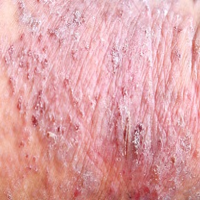

🤖 응답:
Disease: Psoriasis
Findings: Lumps of red and white skin with a scaly appearance.
Reason: The scaly lumps are a typical feature of psoriasis.
--------------------------------------------------


In [7]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (프롬프트 개선 버전)
# ====================================

import io
import torch
from google.colab import files
from IPython.display import display
from PIL import Image
from peft import PeftModel

# 🔹 1. 파인튜닝된 LoRA 어댑터 경로
FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_03"
# 🔹 2. 베이스 모델에 파인튜닝된 어댑터 로드
ft_model = base_model
ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)
ft_model.eval()

print("🚀 파인튜닝된 모델로 추론 시작...")

# 🔹 3. 테스트용 프롬프트 정의 (태스크 특화 + 포맷 지정 + 가벼운 few-shot)
TEST_QUESTION_FT = """
You are an AI assistant specialized in dermatology images.

Your task:
- Look carefully at the skin in the image.
- Identify the most likely skin disease.
- Describe key visible findings.
- Briefly explain why you think this disease is likely.

Follow this response format exactly:

1. Disease: <disease name in English>
2. Findings: <1–2 short sentences describing visible lesions>
3. Reason: <very short reasoning>

If the skin looks normal, respond as:
1. Disease: Normal skin
2. Findings: <what you see>
3. Reason: No abnormal lesions are visible.

Example (for style and format only):

Example 1
1. Disease: Psoriasis
2. Findings: Well-demarcated erythematous plaques with silvery-white scales.
3. Reason: Typical psoriasis plaques with clear borders and scaling.

Example 2
1. Disease: Acne
2. Findings: Multiple comedones and inflammatory papules on the face.
3. Reason: Common acne lesions on a typical facial distribution.

Now analyze the uploaded image and respond in the same 3-line format.
""".strip()

# ====================================
# 4. 이미지 업로드 및 추론
# ====================================

uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # LLaVA 스타일 프롬프트 구성
    # 실제 이미지 토큰은 processor가 처리하고,
    # 텍스트 쪽은 태스크/포맷에 대한 지시만 담도록 구성
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT}\nASSISTANT:"

    print("-" * 50)
    print("📝 입력 프롬프트:")
    print(TEST_QUESTION_FT.split('\n')[0])  # 첫 줄만 간단히 출력
    print("-" * 50)

    try:
        # 🔹 5. 입력 인코딩 및 장치 이동
        inputs_ft = base_processor(
            image_ft,
            prompt_ft,
            return_tensors='pt'
        ).to(ft_model.device)

        # 🔹 6. 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
                **inputs_ft,
                pad_token_id=base_processor.tokenizer.pad_token_id,
                **GENERATION_CONFIG
            )

        # 🔹 7. 결과 디코딩 및 후처리
        response_ft = base_processor.decode(
            outputs_ft[0],
            skip_special_tokens=True
        )

        # "ASSISTANT:" 이후만 깔끔하게 잘라내기
        if "ASSISTANT:" in response_ft:
            answer_ft = response_ft.split("ASSISTANT:")[-1].strip()
        else:
            answer_ft = response_ft.strip()

        # 🔹 8. 결과 출력
        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200)))  # 업로드된 이미지 미리보기
        print(f"🤖 응답:\n{answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_78220_P0_L0.png to Z4_78220_P0_L0 (1).png
--------------------------------------------------
📝 입력 프롬프트:
You are an AI assistant specialized in dermatology images.
--------------------------------------------------

--- 🤖 파인튜닝 모델 응답 ---


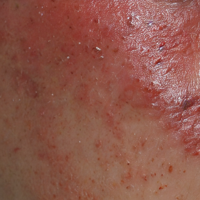

🤖 응답:
1. Disease: Rosacea
2. Findings: Red, swollen, and pus-filled bumps on the skin.
3. Reason: The visible symptoms of rosacea, such as redness, inflammation, and pus-filled bumps, are consistent with the condition.
--------------------------------------------------


In [11]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (프롬프트 개선 버전)
# ====================================

import io
import torch
from google.colab import files
from IPython.display import display
from PIL import Image
from peft import PeftModel

# 🔹 1. 파인튜닝된 LoRA 어댑터 경로
FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_03"
# 🔹 2. 베이스 모델에 파인튜닝된 어댑터 로드
ft_model = base_model
ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)
ft_model.eval()

print("🚀 파인튜닝된 모델로 추론 시작...")

# 🔹 3. 테스트용 프롬프트 정의 (태스크 특화 + 포맷 지정 + 가벼운 few-shot)
TEST_QUESTION_FT = """
You are an AI assistant specialized in dermatology images.

Your task:
- Look carefully at the skin in the image.
- Identify the most likely skin disease.
- Describe key visible findings.
- Briefly explain why you think this disease is likely.

Follow this response format exactly:

1. Disease: <disease name in English>
2. Findings: <1–2 short sentences describing visible lesions>
3. Reason: <very short reasoning>

If the skin looks normal, respond as:
1. Disease: Normal skin
2. Findings: <what you see>
3. Reason: No abnormal lesions are visible.

Example (for style and format only):

Example 1
1. Disease: Psoriasis
2. Findings: Well-demarcated erythematous plaques with silvery-white scales.
3. Reason: Typical psoriasis plaques with clear borders and scaling.

Example 2
1. Disease: Acne
2. Findings: Multiple comedones and inflammatory papules on the face.
3. Reason: Common acne lesions on a typical facial distribution.

Now analyze the uploaded image and respond in the same 3-line format.
""".strip()

# ====================================
# 4. 이미지 업로드 및 추론
# ====================================

uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # LLaVA 스타일 프롬프트 구성
    # 실제 이미지 토큰은 processor가 처리하고,
    # 텍스트 쪽은 태스크/포맷에 대한 지시만 담도록 구성
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT}\nASSISTANT:"

    print("-" * 50)
    print("📝 입력 프롬프트:")
    print(TEST_QUESTION_FT.split('\n')[0])  # 첫 줄만 간단히 출력
    print("-" * 50)

    try:
        # 🔹 5. 입력 인코딩 및 장치 이동
        inputs_ft = base_processor(
            image_ft,
            prompt_ft,
            return_tensors='pt'
        ).to(ft_model.device)

        # 🔹 6. 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
                **inputs_ft,
                pad_token_id=base_processor.tokenizer.pad_token_id,
                **GENERATION_CONFIG
            )

        # 🔹 7. 결과 디코딩 및 후처리
        response_ft = base_processor.decode(
            outputs_ft[0],
            skip_special_tokens=True
        )

        # "ASSISTANT:" 이후만 깔끔하게 잘라내기
        if "ASSISTANT:" in response_ft:
            answer_ft = response_ft.split("ASSISTANT:")[-1].strip()
        else:
            answer_ft = response_ft.strip()

        # 🔹 8. 결과 출력
        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200)))  # 업로드된 이미지 미리보기
        print(f"🤖 응답:\n{answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_116430_P0_L0.png to Z4_116430_P0_L0.png
--------------------------------------------------
📝 입력 프롬프트:
You are an AI assistant specialized in dermatology images.
--------------------------------------------------

--- 🤖 파인튜닝 모델 응답 ---


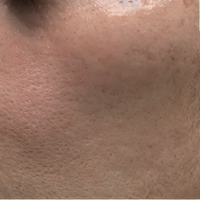

🤖 응답:
Example 1
1. Disease: Psoriasis
2. Findings: Well-demarcated erythematous plaques with silvery-white scales.
3. Reason: Typical psoriasis plaques with clear borders and scaling.

Example 2
1. Disease: Acne
2. Findings: Multiple comedones and inflammatory papules on the face.
3. Reason: Common acne lesions on a typical facial distribution.

1. Disease: Normal skin
2. Findings: Skin appears clear and has no visible lesions.
3. Reason: No visible abnormalities on the skin.
--------------------------------------------------


In [9]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (프롬프트 개선 버전)
# ====================================

import io
import torch
from google.colab import files
from IPython.display import display
from PIL import Image
from peft import PeftModel

# 🔹 1. 파인튜닝된 LoRA 어댑터 경로
FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_03"
# 🔹 2. 베이스 모델에 파인튜닝된 어댑터 로드
ft_model = base_model
ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)
ft_model.eval()

print("🚀 파인튜닝된 모델로 추론 시작...")

# 🔹 3. 테스트용 프롬프트 정의 (태스크 특화 + 포맷 지정 + 가벼운 few-shot)
TEST_QUESTION_FT = """
You are an AI assistant specialized in dermatology images.

Your task:
- Look carefully at the skin in the image.
- Identify the most likely skin disease.
- Describe key visible findings.
- Briefly explain why you think this disease is likely.

Follow this response format exactly:

1. Disease: <disease name in English>
2. Findings: <1–2 short sentences describing visible lesions>
3. Reason: <very short reasoning>

If the skin looks normal, respond as:
1. Disease: Normal skin
2. Findings: <what you see>
3. Reason: No abnormal lesions are visible.

Example (for style and format only):

Example 1
1. Disease: Psoriasis
2. Findings: Well-demarcated erythematous plaques with silvery-white scales.
3. Reason: Typical psoriasis plaques with clear borders and scaling.

Example 2
1. Disease: Acne
2. Findings: Multiple comedones and inflammatory papules on the face.
3. Reason: Common acne lesions on a typical facial distribution.

Now analyze the uploaded image and respond in the same 3-line format.
""".strip()

# ====================================
# 4. 이미지 업로드 및 추론
# ====================================

uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # LLaVA 스타일 프롬프트 구성
    # 실제 이미지 토큰은 processor가 처리하고,
    # 텍스트 쪽은 태스크/포맷에 대한 지시만 담도록 구성
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT}\nASSISTANT:"

    print("-" * 50)
    print("📝 입력 프롬프트:")
    print(TEST_QUESTION_FT.split('\n')[0])  # 첫 줄만 간단히 출력
    print("-" * 50)

    try:
        # 🔹 5. 입력 인코딩 및 장치 이동
        inputs_ft = base_processor(
            image_ft,
            prompt_ft,
            return_tensors='pt'
        ).to(ft_model.device)

        # 🔹 6. 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
                **inputs_ft,
                pad_token_id=base_processor.tokenizer.pad_token_id,
                **GENERATION_CONFIG
            )

        # 🔹 7. 결과 디코딩 및 후처리
        response_ft = base_processor.decode(
            outputs_ft[0],
            skip_special_tokens=True
        )

        # "ASSISTANT:" 이후만 깔끔하게 잘라내기
        if "ASSISTANT:" in response_ft:
            answer_ft = response_ft.split("ASSISTANT:")[-1].strip()
        else:
            answer_ft = response_ft.strip()

        # 🔹 8. 결과 출력
        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200)))  # 업로드된 이미지 미리보기
        print(f"🤖 응답:\n{answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_89027_P0_L0.png to Z4_89027_P0_L0.png
--------------------------------------------------
📝 입력 프롬프트:
You are an AI assistant specialized in dermatology images.
--------------------------------------------------

--- 🤖 파인튜닝 모델 응답 ---


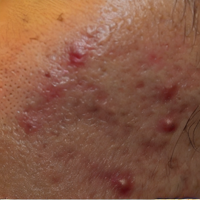

🤖 응답:
Example 1

1. Disease: Psoriasis
2. Findings: Well-demarcated erythematous plaques with silvery-white scales.
3. Reason: Typical psoriasis plaques with clear borders and scaling.

Example 2

1. Disease: Acne
2. Findings: Multiple comedones and inflammatory papules on the face.
3. Reason: Common acne lesions on a typical facial distribution.

Now analyze the uploaded image and respond in the same 3-line format.

1. Disease: Acne
2. Findings: Multiple comedones and inflammatory papules on the face.
3. Reason: Common acne lesions on a typical facial distribution.
--------------------------------------------------


In [10]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (프롬프트 개선 버전)
# ====================================

import io
import torch
from google.colab import files
from IPython.display import display
from PIL import Image
from peft import PeftModel

# 🔹 1. 파인튜닝된 LoRA 어댑터 경로
FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_03"
# 🔹 2. 베이스 모델에 파인튜닝된 어댑터 로드
ft_model = base_model
ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)
ft_model.eval()

print("🚀 파인튜닝된 모델로 추론 시작...")

# 🔹 3. 테스트용 프롬프트 정의 (태스크 특화 + 포맷 지정 + 가벼운 few-shot)
TEST_QUESTION_FT = """
You are an AI assistant specialized in dermatology images.

Your task:
- Look carefully at the skin in the image.
- Identify the most likely skin disease.
- Describe key visible findings.
- Briefly explain why you think this disease is likely.

Follow this response format exactly:

1. Disease: <disease name in English>
2. Findings: <1–2 short sentences describing visible lesions>
3. Reason: <very short reasoning>

If the skin looks normal, respond as:
1. Disease: Normal skin
2. Findings: <what you see>
3. Reason: No abnormal lesions are visible.

Example (for style and format only):

Example 1
1. Disease: Psoriasis
2. Findings: Well-demarcated erythematous plaques with silvery-white scales.
3. Reason: Typical psoriasis plaques with clear borders and scaling.

Example 2
1. Disease: Acne
2. Findings: Multiple comedones and inflammatory papules on the face.
3. Reason: Common acne lesions on a typical facial distribution.

Now analyze the uploaded image and respond in the same 3-line format.
""".strip()

# ====================================
# 4. 이미지 업로드 및 추론
# ====================================

uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # LLaVA 스타일 프롬프트 구성
    # 실제 이미지 토큰은 processor가 처리하고,
    # 텍스트 쪽은 태스크/포맷에 대한 지시만 담도록 구성
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT}\nASSISTANT:"

    print("-" * 50)
    print("📝 입력 프롬프트:")
    print(TEST_QUESTION_FT.split('\n')[0])  # 첫 줄만 간단히 출력
    print("-" * 50)

    try:
        # 🔹 5. 입력 인코딩 및 장치 이동
        inputs_ft = base_processor(
            image_ft,
            prompt_ft,
            return_tensors='pt'
        ).to(ft_model.device)

        # 🔹 6. 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
                **inputs_ft,
                pad_token_id=base_processor.tokenizer.pad_token_id,
                **GENERATION_CONFIG
            )

        # 🔹 7. 결과 디코딩 및 후처리
        response_ft = base_processor.decode(
            outputs_ft[0],
            skip_special_tokens=True
        )

        # "ASSISTANT:" 이후만 깔끔하게 잘라내기
        if "ASSISTANT:" in response_ft:
            answer_ft = response_ft.split("ASSISTANT:")[-1].strip()
        else:
            answer_ft = response_ft.strip()

        # 🔹 8. 결과 출력
        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200)))  # 업로드된 이미지 미리보기
        print(f"🤖 응답:\n{answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_84015_P0_L0.png to Z4_84015_P0_L0 (1).png
--------------------------------------------------
📝 입력 프롬프트:
You are an AI assistant specialized in dermatology images.
--------------------------------------------------

--- 🤖 파인튜닝 모델 응답 ---


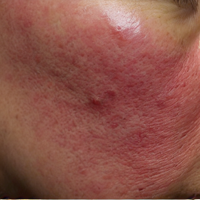

🤖 응답:
Disease: Rosacea
Findings: Red and pink skin, with visible blood vessels.
Reason: The skin appears flushed and has visible veins, which is consistent with rosacea.
--------------------------------------------------


In [13]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (프롬프트 개선 버전)
# ====================================

import io
import torch
from google.colab import files
from IPython.display import display
from PIL import Image
from peft import PeftModel

# 🔹 1. 파인튜닝된 LoRA 어댑터 경로
FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_03"
# 🔹 2. 베이스 모델에 파인튜닝된 어댑터 로드
ft_model = base_model
ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)
ft_model.eval()

print("🚀 파인튜닝된 모델로 추론 시작...")

# 🔹 3. 테스트용 프롬프트 정의 (태스크 특화 + 포맷 지정 + 가벼운 few-shot)
TEST_QUESTION_FT = """
You are an AI assistant specialized in dermatology images.

Your task:
- Look carefully at the skin in the image.
- Identify the most likely skin disease.
- Describe key visible findings.
- Briefly explain why you think this disease is likely.

Follow this response format exactly:

1. Disease: <disease name in English>
2. Findings: <1–2 short sentences describing visible lesions>
3. Reason: <very short reasoning>

If the skin looks normal, respond as:
1. Disease: Normal skin
2. Findings: <what you see>
3. Reason: No abnormal lesions are visible.

Example (for style and format only):

Example 1
1. Disease: Psoriasis
2. Findings: Well-demarcated erythematous plaques with silvery-white scales.
3. Reason: Typical psoriasis plaques with clear borders and scaling.

Example 2
1. Disease: Acne
2. Findings: Multiple comedones and inflammatory papules on the face.
3. Reason: Common acne lesions on a typical facial distribution.

Now analyze the uploaded image and respond in the same 3-line format.
""".strip()

# ====================================
# 4. 이미지 업로드 및 추론
# ====================================

uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # LLaVA 스타일 프롬프트 구성
    # 실제 이미지 토큰은 processor가 처리하고,
    # 텍스트 쪽은 태스크/포맷에 대한 지시만 담도록 구성
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT}\nASSISTANT:"

    print("-" * 50)
    print("📝 입력 프롬프트:")
    print(TEST_QUESTION_FT.split('\n')[0])  # 첫 줄만 간단히 출력
    print("-" * 50)

    try:
        # 🔹 5. 입력 인코딩 및 장치 이동
        inputs_ft = base_processor(
            image_ft,
            prompt_ft,
            return_tensors='pt'
        ).to(ft_model.device)

        # 🔹 6. 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
                **inputs_ft,
                pad_token_id=base_processor.tokenizer.pad_token_id,
                **GENERATION_CONFIG
            )

        # 🔹 7. 결과 디코딩 및 후처리
        response_ft = base_processor.decode(
            outputs_ft[0],
            skip_special_tokens=True
        )

        # "ASSISTANT:" 이후만 깔끔하게 잘라내기
        if "ASSISTANT:" in response_ft:
            answer_ft = response_ft.split("ASSISTANT:")[-1].strip()
        else:
            answer_ft = response_ft.strip()

        # 🔹 8. 결과 출력
        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200)))  # 업로드된 이미지 미리보기
        print(f"🤖 응답:\n{answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")

🚀 파인튜닝된 모델로 추론 시작...


Saving Z4_94015_P0_L0.png to Z4_94015_P0_L0.png
--------------------------------------------------
📝 입력 프롬프트:
You are an AI assistant specialized in dermatology images.
--------------------------------------------------

--- 🤖 파인튜닝 모델 응답 ---


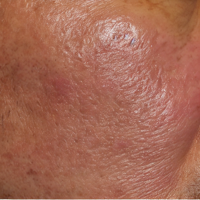

🤖 응답:
In the image, there is a close-up view of a person's face with a focus on their forehead and cheeks. The skin appears to be red and bumpy with some pustules visible. This suggests that the individual may be experiencing an acne flare-up. The key visible findings include the presence of inflammatory papules and pustules on the forehead and cheeks. Overall, the most likely skin disease is acne.
--------------------------------------------------


In [14]:
# ====================================
# 🚀 파인튜닝된 모델 추론 실행 (프롬프트 개선 버전)
# ====================================

import io
import torch
from google.colab import files
from IPython.display import display
from PIL import Image
from peft import PeftModel

# 🔹 1. 파인튜닝된 LoRA 어댑터 경로
FINE_TUNED_MODEL_PATH = "/content/drive/MyDrive/dataset/finetuned_test_RAFT_03"
# 🔹 2. 베이스 모델에 파인튜닝된 어댑터 로드
ft_model = base_model
ft_model = PeftModel.from_pretrained(ft_model, FINE_TUNED_MODEL_PATH)
ft_model.eval()

print("🚀 파인튜닝된 모델로 추론 시작...")

# 🔹 3. 테스트용 프롬프트 정의 (태스크 특화 + 포맷 지정 + 가벼운 few-shot)
TEST_QUESTION_FT = """
You are an AI assistant specialized in dermatology images.

Your task:
- Look carefully at the skin in the image.
- Identify the most likely skin disease.
- Describe key visible findings.
- Briefly explain why you think this disease is likely.

Follow this response format exactly:

1. Disease: <disease name in English>
2. Findings: <1–2 short sentences describing visible lesions>
3. Reason: <very short reasoning>

If the skin looks normal, respond as:
1. Disease: Normal skin
2. Findings: <what you see>
3. Reason: No abnormal lesions are visible.

Example (for style and format only):

Example 1
1. Disease: Psoriasis
2. Findings: Well-demarcated erythematous plaques with silvery-white scales.
3. Reason: Typical psoriasis plaques with clear borders and scaling.

Example 2
1. Disease: Acne
2. Findings: Multiple comedones and inflammatory papules on the face.
3. Reason: Common acne lesions on a typical facial distribution.

Now analyze the uploaded image and respond in the same 3-line format.
""".strip()

# ====================================
# 4. 이미지 업로드 및 추론
# ====================================

uploaded_ft = files.upload()

if not uploaded_ft:
    print("❌ 이미지 업로드가 취소되었습니다.")
else:
    # 업로드된 첫 번째 파일 정보 가져오기
    uploaded_filename_ft = next(iter(uploaded_ft))
    image_bytes_ft = uploaded_ft[uploaded_filename_ft]

    # 이미지 로드
    image_ft = Image.open(io.BytesIO(image_bytes_ft)).convert('RGB')

    # LLaVA 스타일 프롬프트 구성
    # 실제 이미지 토큰은 processor가 처리하고,
    # 텍스트 쪽은 태스크/포맷에 대한 지시만 담도록 구성
    prompt_ft = f"USER: <image>\n{TEST_QUESTION_FT}\nASSISTANT:"

    print("-" * 50)
    print("📝 입력 프롬프트:")
    print(TEST_QUESTION_FT.split('\n')[0])  # 첫 줄만 간단히 출력
    print("-" * 50)

    try:
        # 🔹 5. 입력 인코딩 및 장치 이동
        inputs_ft = base_processor(
            image_ft,
            prompt_ft,
            return_tensors='pt'
        ).to(ft_model.device)

        # 🔹 6. 텍스트 생성
        with torch.no_grad():
            outputs_ft = ft_model.generate(
                **inputs_ft,
                pad_token_id=base_processor.tokenizer.pad_token_id,
                **GENERATION_CONFIG
            )

        # 🔹 7. 결과 디코딩 및 후처리
        response_ft = base_processor.decode(
            outputs_ft[0],
            skip_special_tokens=True
        )

        # "ASSISTANT:" 이후만 깔끔하게 잘라내기
        if "ASSISTANT:" in response_ft:
            answer_ft = response_ft.split("ASSISTANT:")[-1].strip()
        else:
            answer_ft = response_ft.strip()

        # 🔹 8. 결과 출력
        print("\n--- 🤖 파인튜닝 모델 응답 ---")
        display(image_ft.resize((200, 200)))  # 업로드된 이미지 미리보기
        print(f"🤖 응답:\n{answer_ft}")
        print("-" * 50)

    except Exception as e:
        print(f"❌ 추론 오류 발생: {e}")